## Installing all the required modules

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import pandas as pd

%matplotlib inline

In [9]:
df_airline = pd.read_csv("airline_passengers.csv")
df_airline.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [10]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [11]:
df_airline.tail()

,Month,Thousands of Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [12]:
df_airline.dropna(axis=0, inplace = True)

In [13]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [14]:
df_airline['Month'] = pd.to_datetime(df_airline['Month'])

In [15]:
df_airline.set_index('Month', inplace=True)

In [16]:
df_airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<AxesSubplot:xlabel='Month'>

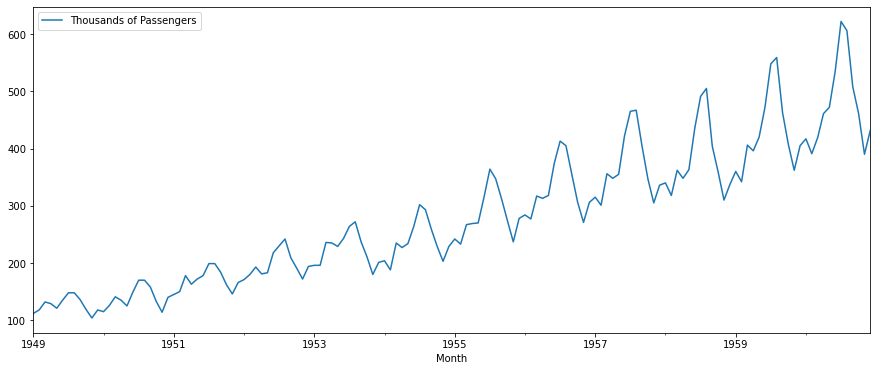

In [17]:
df_airline.plot(figsize=(15,6))

We can see that the data is season in nature with an upward trend. Now to convert it into stationary data, we need to use DICKEY FULLER TEST.

### Applying Dickey Fuller Test

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1]<0.05:
        print('Strong evidence against null hypothesis')
    else:
        print('Weak evidence against null hypothesis')

In [20]:
adf_test(df_airline['Thousands of Passengers'])

ADF Statistics: 0.815368879206053
p-value: 0.9918802434376411
Weak evidence against null hypothesis


This hypothesis fail shows that data is not stationary. Now we need to perform differencing.

#### Differencing technique

In [21]:
df_airline['Passengers first difference'] = df_airline['Thousands of Passengers'] - df_airline['Thousands of Passengers'].shift(1)

In [22]:
df_airline.head()

,Thousands of Passengers,Passengers first difference
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,6.0
1949-03-01,132.0,14.0
1949-04-01,129.0,-3.0
1949-05-01,121.0,-8.0


In [23]:
adf_test(df_airline['Passengers first difference'].dropna())

ADF Statistics: -2.829266824169997
p-value: 0.05421329028382577
Weak evidence against null hypothesis


Still our hypothesis didn't get accepted. We again have to perform the differencing

In [24]:
df_airline['Passengers second difference'] = df_airline['Passengers first difference'] - df_airline['Passengers first difference'].shift(1)

In [25]:
adf_test(df_airline['Passengers second difference'].dropna())

ADF Statistics: -16.384231542468477
p-value: 2.732891850014397e-29
Strong evidence against null hypothesis


Now we have a strong evidence against the null hypothesis. Thus we can say that our cofficient "d = 2".
We know the data is seasonal thus we need to use 12 months or 12 shift difference

In [30]:
df_airline['Passengers 12 difference'] = df_airline['Thousands of Passengers'] - df_airline['Thousands of Passengers'].shift(12)

In [31]:
adf_test(df_airline['Passengers 12 difference'].dropna())

ADF Statistics: -3.3830207264924805
p-value: 0.011551493085514982
Strong evidence against null hypothesis


In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

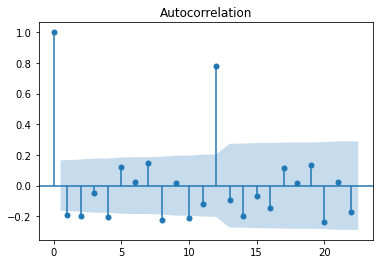

In [27]:
acf = plot_acf(df_airline['Passengers second difference'].dropna())

'q' can be given as 12 as the most significant correlation is found on 12th address.

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


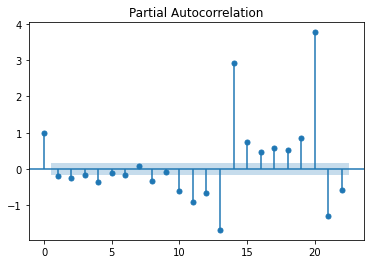

In [28]:
pacf = plot_pacf(df_airline['Passengers second difference'].dropna())

'P' can be given the value 14, 19 as the most significant correlations are at those lags. 

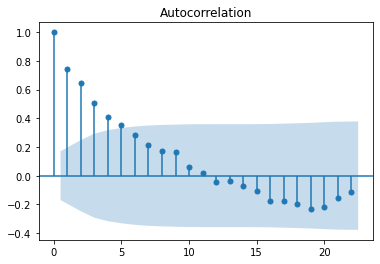

In [32]:
acf = plot_acf(df_airline['Passengers 12 difference'].dropna())

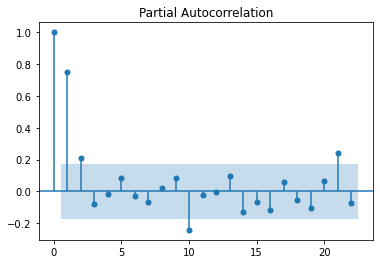

In [33]:
pacf = plot_pacf(df_airline['Passengers 12 difference'].dropna())

## Preparing the ARIMA Model

In [34]:
from datetime import datetime, timedelta
train_dataset_end = datetime(1955,12,1)
test_dataset_end = datetime(1960,12,1)

In [36]:
train_data = df_airline[:train_dataset_end]
test_data = df_airline[train_dataset_end+timedelta(days=1):test_dataset_end]

In [37]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [40]:
from statsmodels.tsa.arima_model import ARIMA

In [46]:
model_ARIMA = ARIMA(train_data['Thousands of Passengers'], order = (10,2,0))

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [47]:
mode_ARIMA_fit = model_ARIMA.fit()

In [48]:
mode_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                  
======================================================================================
Dep. Variable:     D2.Thousands of Passengers   No. Observations:                   82
Model:                        ARIMA(10, 2, 0)   Log Likelihood                -357.239
Method:                               css-mle   S.D. of innovations             18.333
Date:                        Tue, 31 Jan 2023   AIC                            738.477
Time:                                16:53:58   BIC                            767.358
Sample:                            03-01-1949   HQIC                           750.072
                                 - 12-01-1955                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.0164      0.347      0.047      0.962      -0.665       0.697
ar.L1.D2.Thousands of Passengers     -0.5165      0.097     -5.300      0.000      -0.707      -0.325
ar.L2.D2.Thousands of Passengers     -0.7203      0.108     -6.650      0.000      -0.933      -0.508
ar.L3.D2.Thousands of Passengers     -0.4856      0.120     -4.032      0.000      -0.722      -0.250
ar.L4.D2.Thousands of Passengers     -0.7506      0.131     -5.717      0.000      -1.008      -0.493
ar.L5.D2.Thousands of Passengers     -0.5065      0.151     -3.360      0.001      -0.802      -0.211
ar.L6.D2.Thousands of Passengers     -0.5204      0.149     -3.500      0.000      -0.812      -0.229
ar.L7.D2.Thousands of Passengers     -0.3055      0.136     -2.250      0.024      -0.572      -0.039
ar.L8.D2.Thousands of Passengers     -0.5943      0.125     -4.744      0.000      -0.840      -0.349
ar.L9.D2.Thousands of Passengers     -0.2966      0.116     -2.556      0.011      -0.524      -0.069
ar.L10.D2.Thousands of Passengers    -0.4826      0.101     -4.765      0.000      -0.681      -0.284
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9098           -0.5670j            1.0720           -0.0887
AR.2             0.9098           +0.5670j            1.0720            0.0887
AR.3             0.4844           -0.9210j            1.0406           -0.1729
AR.4             0.4844           +0.9210j            1.0406            0.1729
AR.5            -0.9676           -0.4146j            1.0527           -0.4356
AR.6            -0.9676           +0.4146j            1.0527            0.4356
AR.7            -0.6004           -0.8889j            1.0726           -0.3445
AR.8            -0.6004           +0.8889j            1.0726            0.3445
AR.9            -0.1335           -1.1349j            1.1427           -0.2686
AR.10           -0.1335           +1.1349j            1.1427            0.2686
------------------------------------------------------------------------------
"""

In [50]:
pred = mode_ARIMA_fit.predict(start = pred_start_date, end = pred_end_date)
residual = test_data['Thousands of Passengers'] - pred

<AxesSubplot:ylabel='Density'>

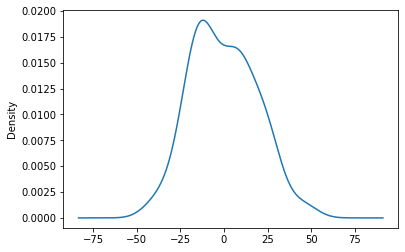

In [52]:
mode_ARIMA_fit.resid.plot(kind = 'kde')

In [53]:
test_data['Predicted_ARIMA'] = pred

<ipython-input-53-90918ede9522>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_ARIMA'] = pred


<AxesSubplot:xlabel='Month'>

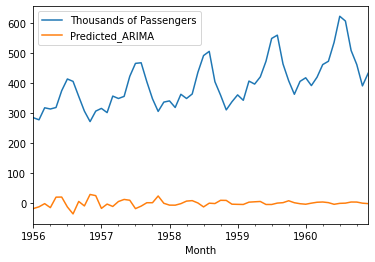

In [54]:
test_data[['Thousands of Passengers','Predicted_ARIMA']].plot()